ОПИСАНИЕ ЗАДАЧИ|

Этот датасет содержит характеристики районов Бостона, описанные ниже. Будем предсказывать медианную цену дилья по характеристикам района.

Описание колонок:

CRIM: уровень преступности на душу населения 

ZN: доля жилых земель, выделенных под участки площадью более 25 000 кв. футов

INDUS: доля некоммерческих земельных участков 

CHAS: фиктивная переменная для реки Чарльз (1, если участок граничит с рекой; 0 в противном случае)

NOX: концентрация оксидов азота (частей на 10 миллионов)

RM: среднее количество комнат на жилье

AGE: доля жилых единиц, построенных до 1940 года

DIS: взвешенные расстояния до пяти центров занятости Бостона

RAD: индекс доступности к радиальным автомагистралям

TAX: ставка налога на собственность с полной стоимостью за $10 000

PTRATIO: соотношение учеников и учителей

B: результат уравнения B=1000(Bk - 0.63)^2, где Bk — доля чернокожих по городу﻿

LSTAT: % населения с низким социальным статусом

Output variable:

MEDV: медианная стоимость домов, занятых собственниками, в тысячах долларов

ИМПОРТ ОСНОВНЫХ БИБЛИОТЕК

In [459]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [513]:
from help import *
from plot import * 
import random
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [461]:
# фиксируем состояние генератора псевдослучайных чисел для воспроизводимости результатов модели из раза в раз
SEED = 52 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

1. ИЗУЧЕНИЕ СТРУКТУРЫ ДАННЫХ

In [462]:
# Загружаем датасет в среду и выводим первые 5 наблюдений
df = pd.read_csv('boston.csv')
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [463]:
#Смотрим на типы данных и кол-во значений
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Видим, что пропущенных значений нет, RAD и CHAS потенциально категориальные переменные т.к. int. Из описания CHAS бинарная, проверим RAD

In [464]:
df['RAD'].value_counts()

RAD
24    132
5     115
4     110
3      38
6      26
2      24
8      24
1      20
7      17
Name: count, dtype: int64

9 уникальных значений, имеющих порядковую зависимость (индекс доступности -- оставим как числовую)

In [465]:
df.CHAS.value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

In [466]:
#Выводим статистики распределений признаков и отклика. 
# Сюда войдет часть категориальных из-за кодировки не как object, можно посмотреть и их (CHAS и RAD)
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<Axes: >

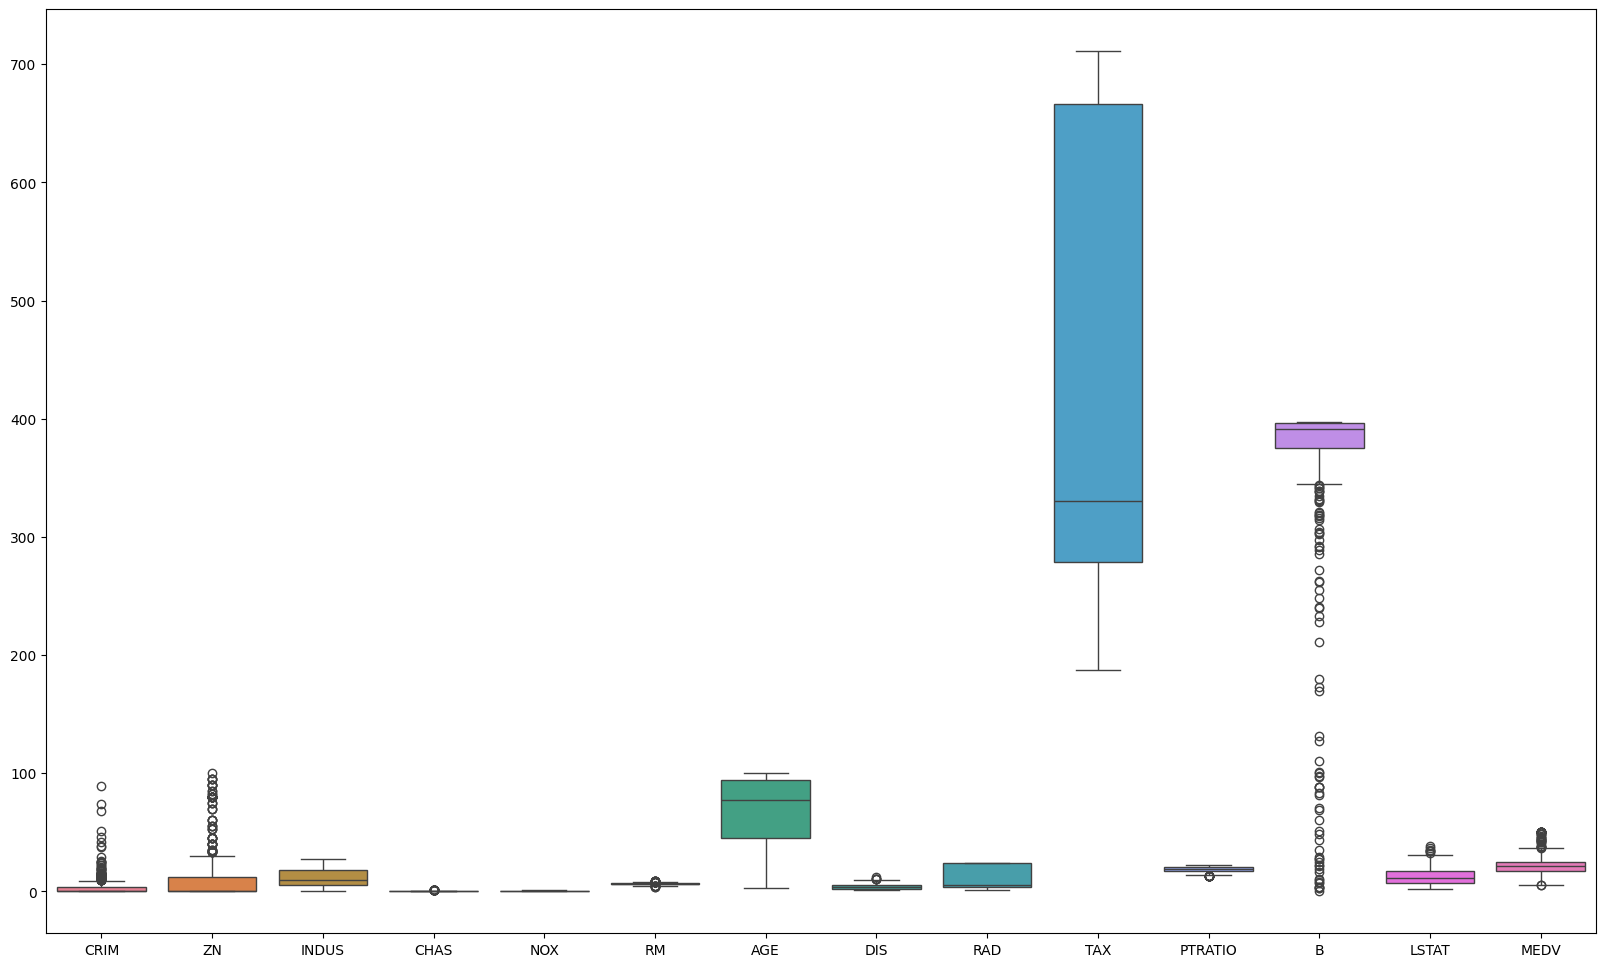

In [467]:
plt.figure(figsize = (20,12))
sns.boxplot(df)

В CRIM, ZN, DIS, B, LSTAT, MEDV много выбросов.

2. Проверка на корректность и качество данных

In [468]:
#Посмотрим пропущенные значения точно
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Пропущенных значений нет.

In [469]:
#Смотрим дубликаты 
df.duplicated().sum()

np.int64(0)

Дубликатов не найдено. Удалять нечего.

Смотрим 
CRIM > 0 (преступность на душу)
ZN, INDUS, AGE, LSTAT от 0 до 100 (все доли -- корректно)
Остальные переменные положительны и укладываются в свои предполагаемые значения.

3. Детальное изучение признаков и таргета. 
Используем написанные функции plot_(numeric/categorical)_hist и не только

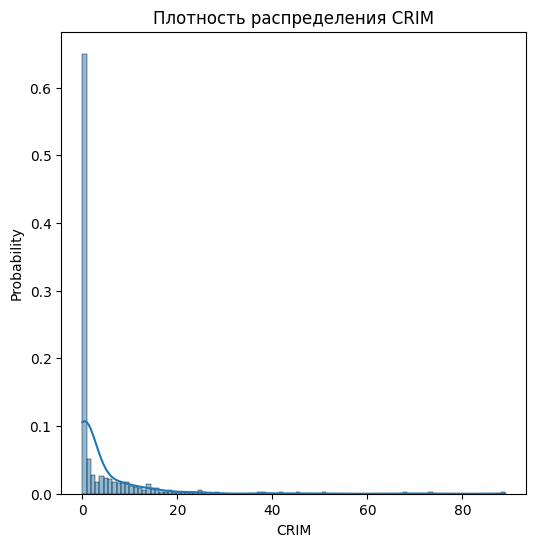

In [470]:
#Строим гистограмму распределения CRIM
plot_hist(df, 'CRIM')

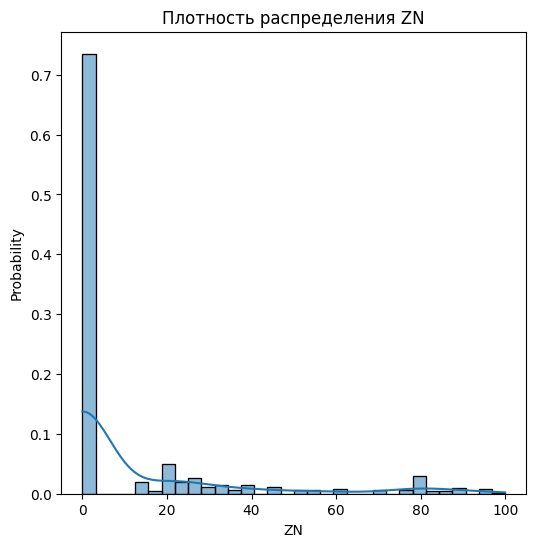

In [471]:
#Строим гистограмму распределения ZN
plot_hist(df, 'ZN')

Оба признака имеют огромный хвост справа и почти все значения в самом нуле -- нужно логарифмировать для сглаживания шкалы (log1p как вариант или просто log так как тут положительные значения). Много значений в нуле т.к. либо нулевая преступность либо нет огромных помещений.

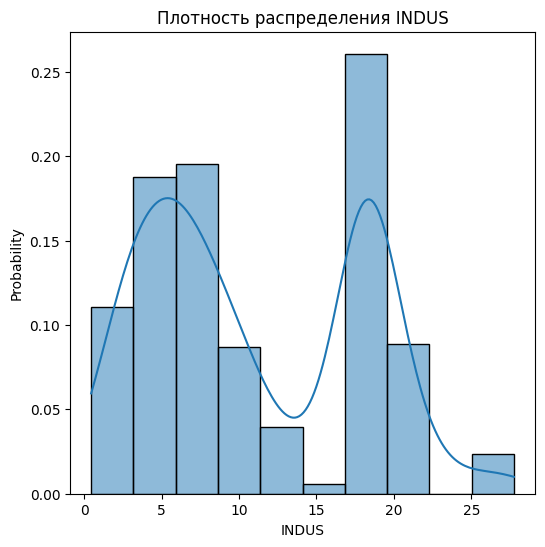

In [472]:
#Строим гистограмму распределения INDUS
plot_hist(df, 'INDUS')

Два пика -- бимодальность. Для моделей деревьев это не проблема. Заметных выбросов немного. Оставим как есть

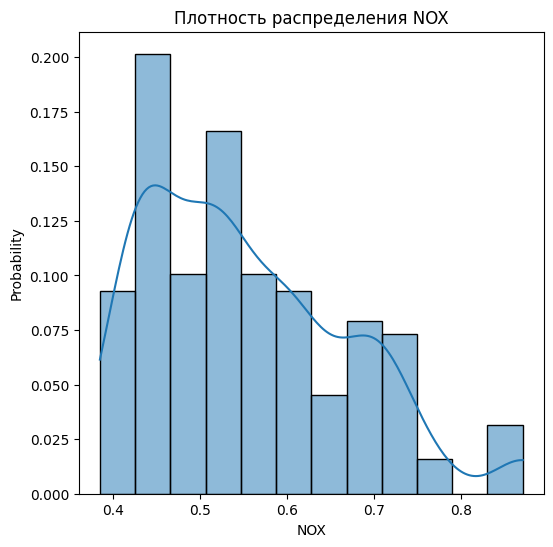

In [473]:
#Строим гистограмму распределения NOX
plot_hist(df, 'NOX')

Все отлично, нет тяжелых хвостов.

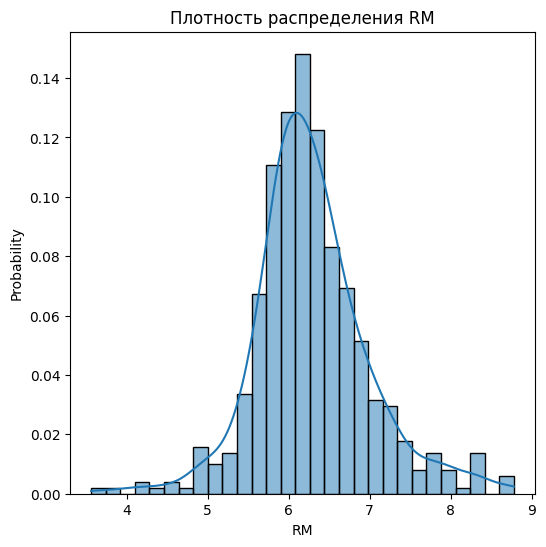

In [474]:
#Строим гистограмму распределения RM
plot_hist(df, 'RM')

Примерно нормальное распределение. Отлично.

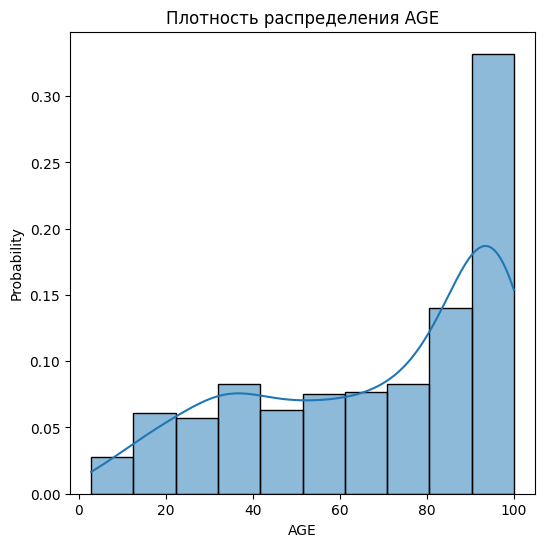

In [475]:
#Строим гистограмму распределения AGE
plot_hist(df, 'AGE')

Похоже на uniform но с пиком в 100 -- просто много районов только старой застройки (оставим, все нормально)

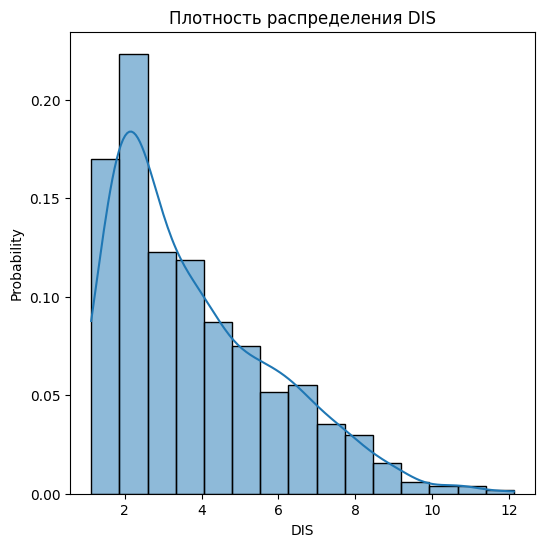

In [476]:
#Строим гистограмму распределения DIS
plot_hist(df, 'DIS')

Все отлично, признак без тяжелых хвостов и с одним пиком

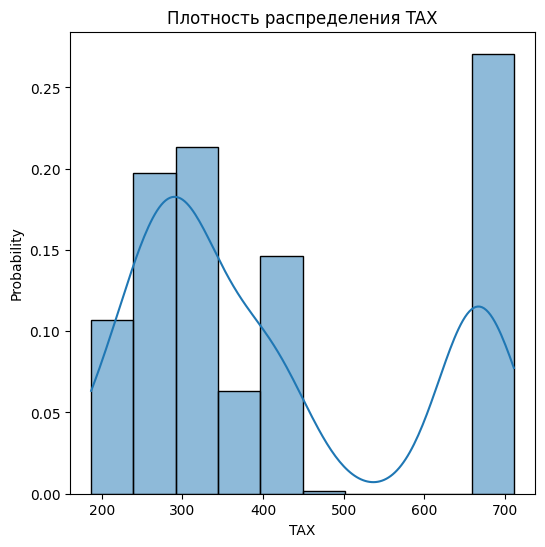

In [477]:
#Строим гистограмму распределения TAX
plot_hist(df, 'TAX')

Явный пробел между двумя группами -- имеет смысл разделить 200-500 на low и остальное на high.

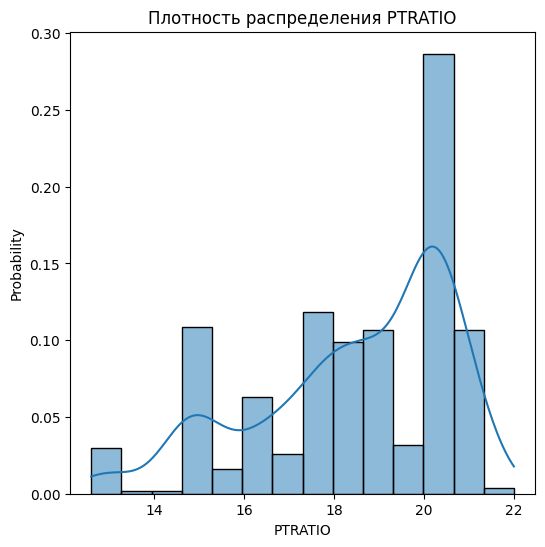

In [478]:
#Строим гистограмму распределения PTRATIO
plot_hist(df, 'PTRATIO')

Примерно нормальное. Оставим.

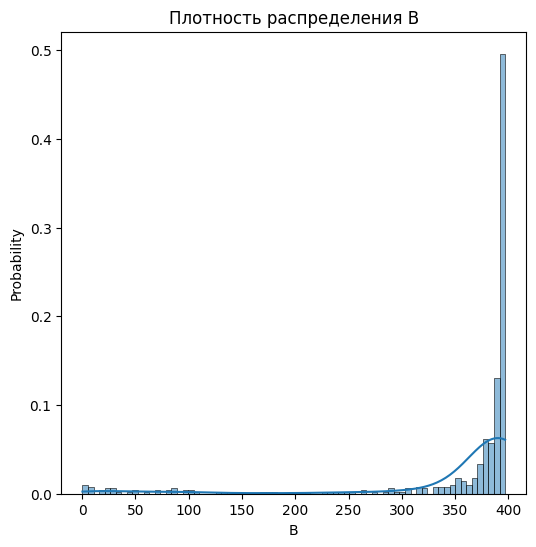

In [479]:
#Строим гистограмму распределения B
plot_hist(df, 'B')

Аномальная концентрация почти всех значений в районе 350-400. Есть смысл выбросить все <300 

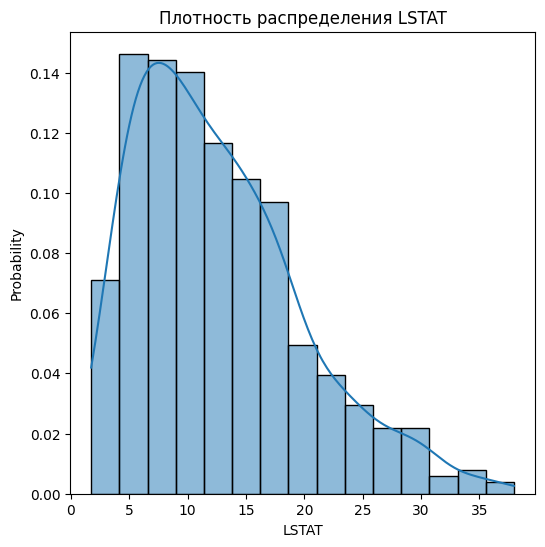

In [480]:
#Строим гистограмму распределения LSTAT
plot_hist(df, 'LSTAT')

Примерно нормальное. Оставим.

Категориальные + Отклик.

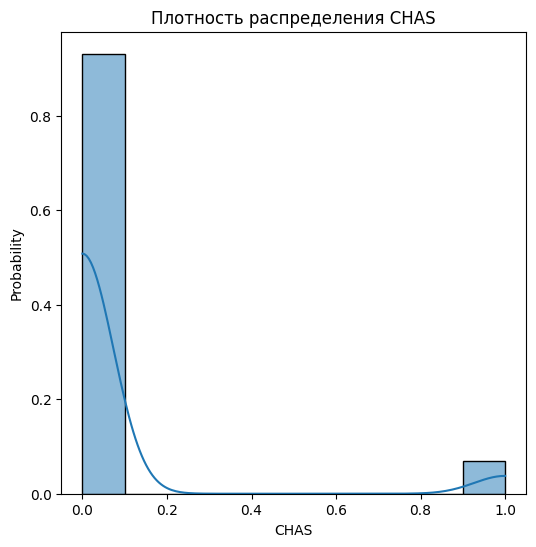

In [481]:
#Строим гистограмму распределения CHAS
plot_hist(df, 'CHAS')

Бинарная. Оставляем. Почти никакие не граничат с рекой.

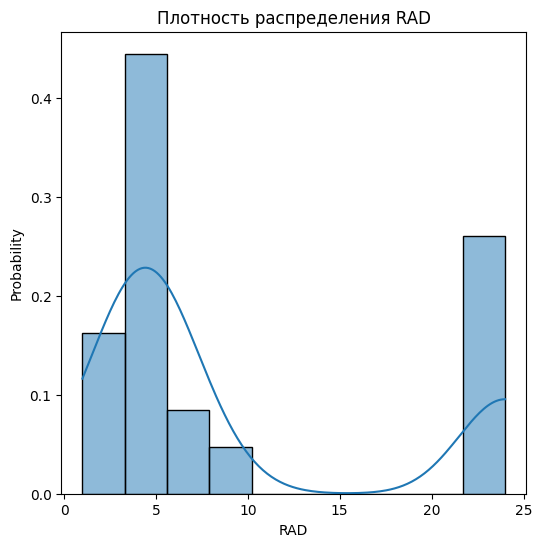

In [482]:
#Строим гистограмму распределения RAD
plot_hist(df, 'RAD')

Бимодальный категориальный признак. Либо низкая доступность, либо очень высокая, стоит разделить на две категории <10 и >10

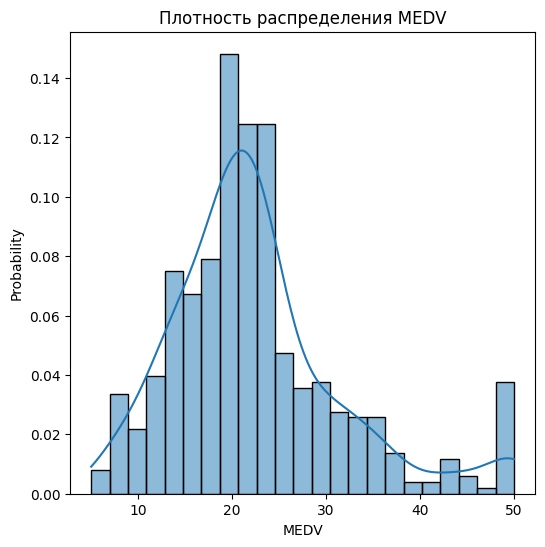

In [483]:
#Строим гистограмму распределения отклика MEDV
plot_hist(df, 'MEDV')

Примерно нормальное. Отлично.

4. ИЗУЧЕНИЕ ВЗАИМОСВЯЗЕЙ МЕЖДУ ПРИЗНАКАМИ.

In [516]:
# Посмотрим на VIF каждого признака
vif_results = quick_vif_check_sklearn(df, df.columns)

VIF ANALYSIS (using sklearn)
VIF > 10: ❌ High multicollinearity
VIF 5-10: ⚠️ Moderate multicollinearity
VIF < 5: ✅ Acceptable

⚠️ MODERATE | TAX                       | VIF:   9.21
⚠️ MODERATE | RAD                       | VIF:   7.81
✅ OK | NOX                       | VIF:   4.59
✅ OK | DIS                       | VIF:   4.40
✅ OK | INDUS                     | VIF:   3.99
✅ OK | MEDV                      | VIF:   3.86
✅ OK | LSTAT                     | VIF:   3.58
✅ OK | AGE                       | VIF:   3.10
✅ OK | ZN                        | VIF:   2.35
✅ OK | RM                        | VIF:   2.26
✅ OK | PTRATIO                   | VIF:   1.99
✅ OK | CRIM                      | VIF:   1.83
✅ OK | B                         | VIF:   1.38
✅ OK | CHAS                      | VIF:   1.10


TAX и RAD настораживают, в основном все отлично.

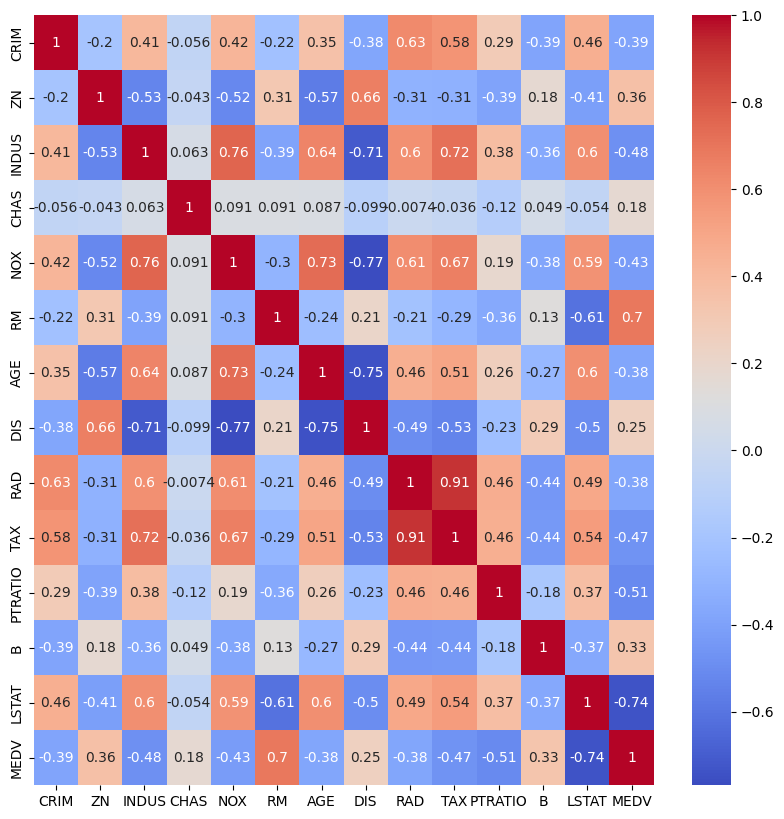

In [484]:
plt.figure(figsize = (10,10))
corr = sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True)

Линейная корреляция пригодится для определения знака взаимосвязи и перепроверки phik.

interval columns not set, guessing: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


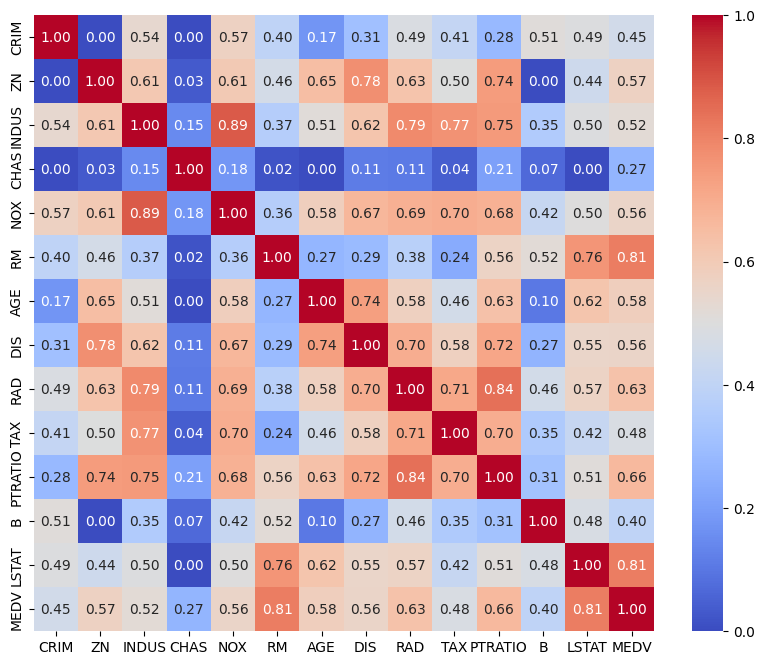

In [485]:
plot_phik(df)

Явно есть мультиколлинеарность со значениями phik 0.70-0.89. (Помним, что RAD категориальная)
Самые сильные пары:

MEDV - LSTAT 0.81

MEDV - RM 0.81

LSTAT - RM 0.76

RAD - PTRATIO 0.84

INDUS - NOX 0.89

INDUS - RAD 0.79

ZN - DIS 0.78

INDUS - TAX 0.77

In [486]:
corr = df.phik_matrix()
corr = np.abs(corr[corr!=1]).fillna(0)
(corr.sum(axis=0)/(corr.shape[0]-1)).sort_values(ascending = False)


interval columns not set, guessing: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


PTRATIO    0.584760
RAD        0.581536
NOX        0.570004
INDUS      0.566120
MEDV       0.562809
DIS        0.528927
LSTAT      0.512120
TAX        0.488382
ZN         0.463175
AGE        0.453756
RM         0.418340
CRIM       0.355498
B          0.325998
CHAS       0.090505
dtype: float64

Выше признаки с самой высокой средней корреляцией. Часть их имеет смысл отбросить как линейную комбинацию других. Изобразим их пары.

<Figure size 1600x1600 with 0 Axes>

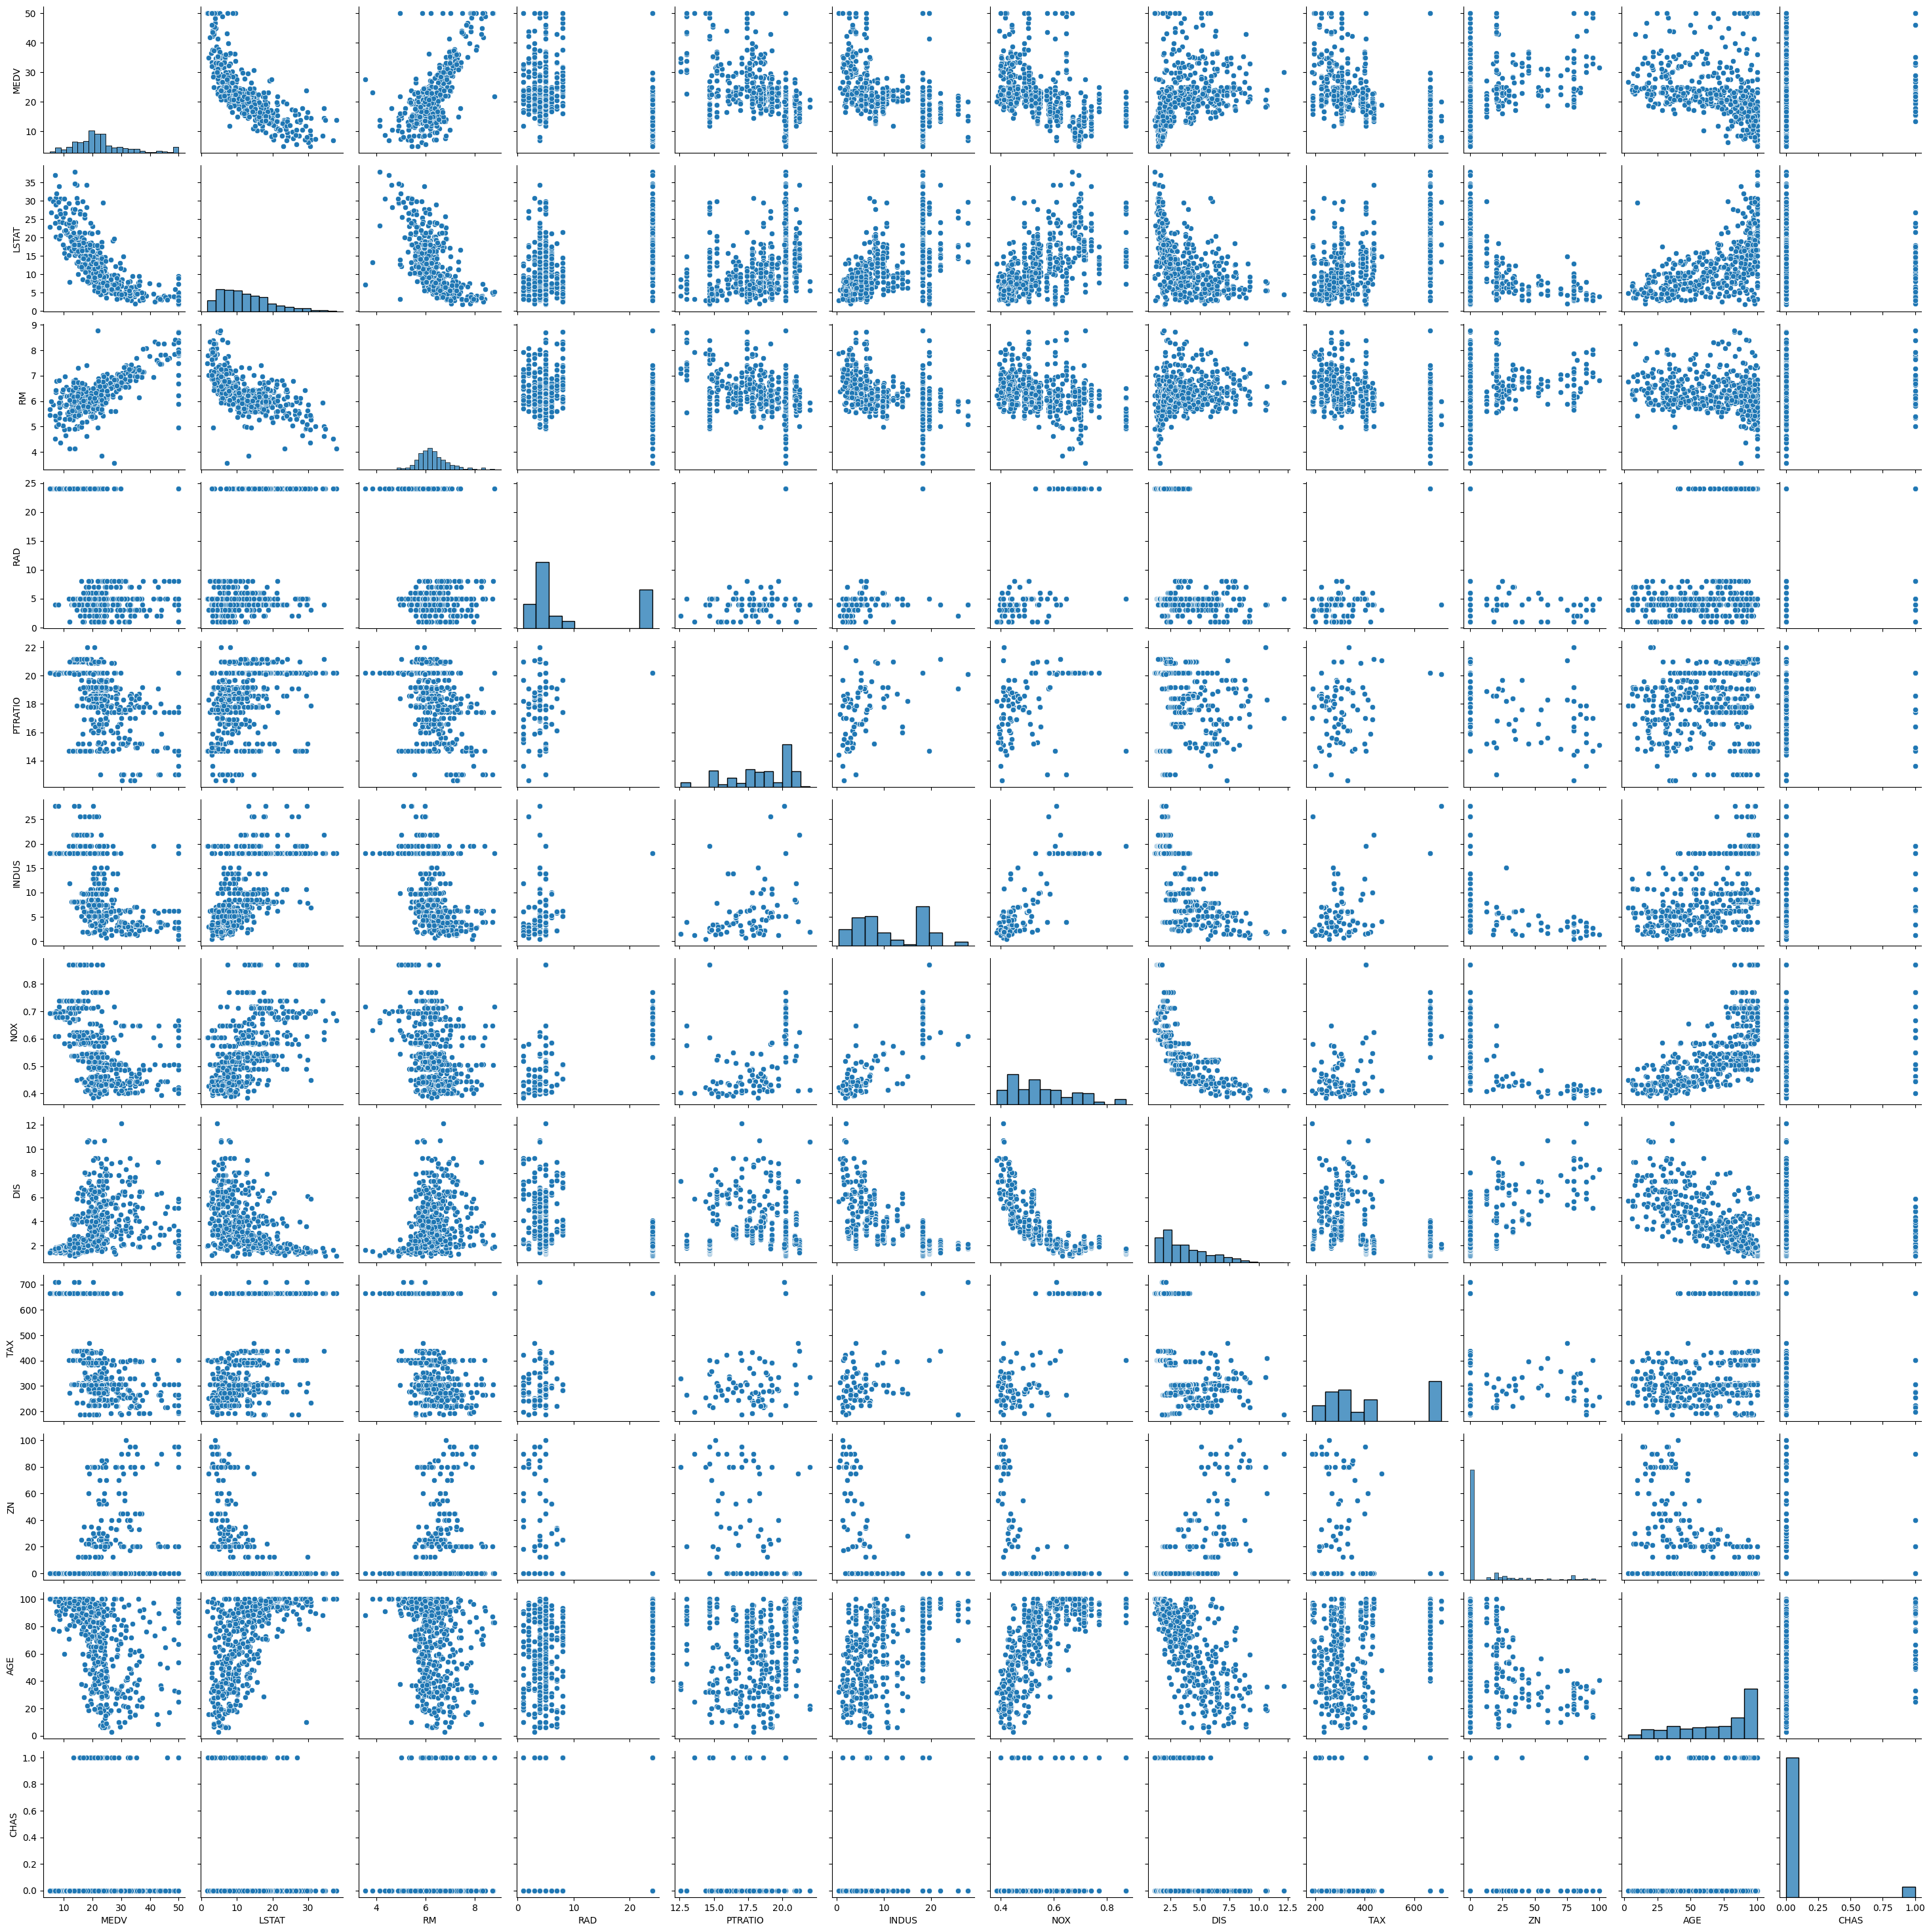

In [512]:
plt.figure(figsize = (16,16))
sns.pairplot(df[['MEDV', 'LSTAT', 'RM', 'RAD', 'PTRATIO', 'INDUS', 'NOX', 'DIS', 'TAX', 'ZN', 'AGE', 'CHAS']])

Как видим, есть заметная зависимость между:

MEDV-LSTAT (обратная линейная) - чем больше % неблагополучного населения, тем ниже цен

MEDV-RM (прямая линейная) - чем больше комнат, тем выше цена

И соответственно обратная между двумя признаками LSTAT RM - больше неблагополучного населения, тем меньше комнат на жилье

В случае категориальной переменной RAD зависимости неочевидны, но линейная корреляция с TAX 0.91 и вообще положительная с INDUS и PTRATIO - 
чем доступнее автомагистраль, тем выше налог и доля некомерческих участков + учителей на ученика. Близость автомагистралей вызывает 
большие налоги, много учителей (выше качество образования) и много жилых домов. Вероятно, это все признаки богатства,
 хотя сам RAD крайне плохо коррелирует с MEDV

INDUS (прямая) c NOX и TAX - чем больше доля некоммерческих участков, тем больше вредного в воздухе и выше налоги на собственность

ZN-DIS (прямая линейная ) - чем больше расстоние до центра, тем выше доля земель под огромные постройки (промзона и кластеры для бедных видимо)

5. ПРЕПРОЦЕССИНГ ДАННЫХ.

Поскольку пропусков нет, обрабатывать нечего (можно было бы с label/ordinal encoder, knn, частотным методом). Поделим на X и y, train и test.

In [488]:
X, y = divide_data(df, 'MEDV')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED) 

In [490]:
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
260,0.54011,20.0,3.97,0,0.647,7.203,81.8,2.1121,5,264.0,13.0,392.80,9.59
295,0.12932,0.0,13.92,0,0.437,6.678,31.1,5.9604,4,289.0,16.0,396.90,6.27
497,0.26838,0.0,9.69,0,0.585,5.794,70.6,2.8927,6,391.0,19.2,396.90,14.10
262,0.52014,20.0,3.97,0,0.647,8.398,91.5,2.2885,5,264.0,13.0,386.86,5.91
384,20.08490,0.0,18.10,0,0.700,4.368,91.2,1.4395,24,666.0,20.2,285.83,30.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.49632,0.0,19.58,0,0.871,5.404,100.0,1.5916,5,403.0,14.7,341.60,13.28
13,0.62976,0.0,8.14,0,0.538,5.949,61.8,4.7075,4,307.0,21.0,396.90,8.26
267,0.57834,20.0,3.97,0,0.575,8.297,67.0,2.4216,5,264.0,13.0,384.54,7.44
156,2.44668,0.0,19.58,0,0.871,5.272,94.0,1.7364,5,403.0,14.7,88.63,16.14


In [491]:
#стандартизируем все переменные кроме бинарной (даже диксретную порядковую)
numeric_cols = X.columns.drop('CHAS')
categoric_cols = ['CHAS']
preprocessor = ColumnTransformer(transformers =[(
'num', StandardScaler(), numeric_cols),
('cat', 'passthrough', categoric_cols)])
X_processed_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns = X_train.columns)
X_processed_test = pd.DataFrame(preprocessor.transform(X_test), columns = X_train.columns)

In [492]:
preprocessor = Pipeline([
    # Шаг 1: Заполнение пропусков
    ('standartizer', ColumnTransformer([
('num', StandardScaler(), numeric_cols),
('cat', 'passthrough', categoric_cols)],
        remainder='passthrough',  # колонки, не указанные в трансформерах, передаются без изменений
        verbose_feature_names_out=False  # не добавлять префиксы к именам колонок
    ))])
    # Устанавливаем вывод в формате pandas DataFrame (для sklearn версии 1.0 и выше)
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('standartizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')),
                                                 ('cat', 'passthrough',
                                                  ['CHAS'])],
                                   verbose_feature_names_out=False))])

In [493]:
X_processed_train = preprocessor.fit_transform(X_train)
X_processed_test = preprocessor.transform(X_test)

6. ПОСТРОЕНИЕ BASELINE МОДЕЛИ.

In [494]:
X_processed_test.shape

(102, 13)

In [495]:
feature_names = X_processed_test.columns.to_list()

6.1 DUMMY REGRESSOR

Возьмем для простоты модель, которая постоянно будет предсказывать среднее значение, как на первой стадии построения дерева решений.

In [496]:
#Здесь предсказание константно, можно было без стандартизации
dummy_regressor = DummyRegressor(strategy = 'mean')
dummy_regressor.fit(X_processed_train, y_train)
y_pred = dummy_regressor.predict(X_processed_test)

dummy_regressor_metrics = evaluate_regression(y_test, y_pred, model_name = 'DummyRegressor')


                 DUMMYREGRESSOR EVALUATION                  

MAIN METRICS:
Metric   Value
   MAE  7.4082
   MSE 95.4474
   R^2 -0.0011
 RMSLE  0.4285



6.2 ЛИНЕЙНАЯ РЕГРЕССИЯ

In [497]:

lin_reg = LinearRegression()
lin_reg.fit(X_processed_train, y_train)
y_pred = lin_reg.predict(X_processed_test)

lin_reg_metrics = evaluate_regression(y_test, y_pred, model_name = 'LinearRegression')


                LINEARREGRESSION EVALUATION                 

MAIN METRICS:
Metric   Value
   MAE  3.1745
   MSE 23.1124
   R^2  0.7576
 RMSLE  0.2105



/Users/user/ml_регрессия_Богдан/plot.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


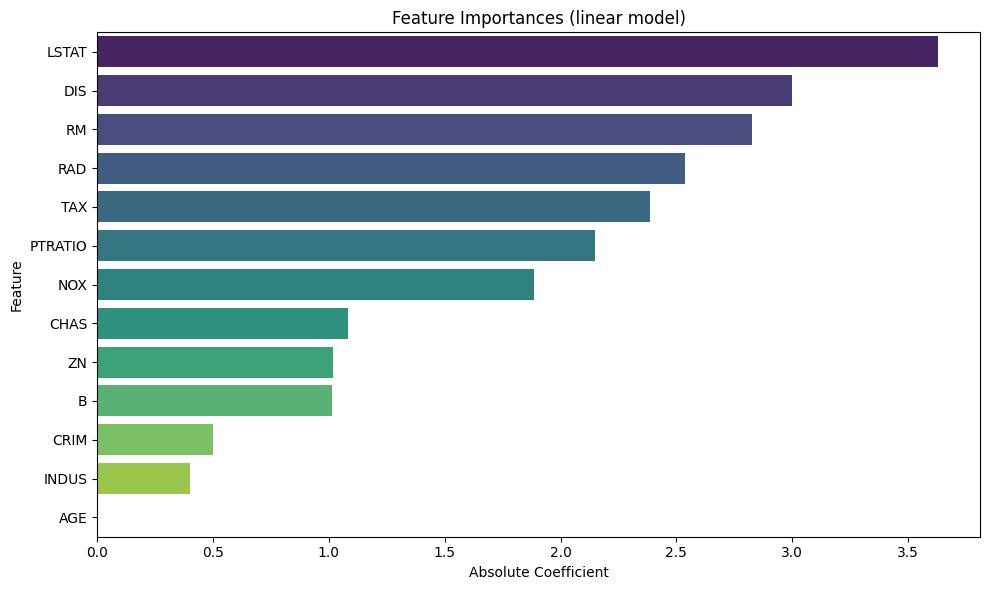

,Feature,Importance
11,LSTAT,3.628462
6,DIS,2.998991
4,RM,2.825437
7,RAD,2.537238
8,TAX,2.384538
9,PTRATIO,2.147859
3,NOX,1.886487
12,CHAS,1.083485
1,ZN,1.019103
10,B,1.014571


In [498]:
plot_feature_importance(lin_reg, feature_names)
#Ниже коэффициенты стандартизированных признаков по убыванию. Все примерно соответствует корреляции признаков с Y

6. ДЕРЕВО РЕШЕНИЙ

In [499]:
decision_tree = DecisionTreeRegressor(random_state = SEED, max_depth = 4)
decision_tree.fit(X_processed_train, y_train)
y_pred = decision_tree.predict(X_processed_test)
decision_tree_metrics = evaluate_regression(y_test, y_pred, model_name = 'DecisionTreeRegressor')


              DECISIONTREEREGRESSOR EVALUATION              

MAIN METRICS:
Metric   Value
   MAE  3.0239
   MSE 18.7157
   R^2  0.8037
 RMSLE  0.1926



Тут уже на первом и втором местах признаки с самой высокой корреляцией с откликом, хотя PTRATIO с почти самой высокой корреляцией с откликом оказался на последнем месте, а CRIM с самым низким - на третьем. DIS и NOX до этого имели высокую корреляцию с Y. Так что кроме CRIM вклад всех факторов объясним.

/Users/user/ml_регрессия_Богдан/plot.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


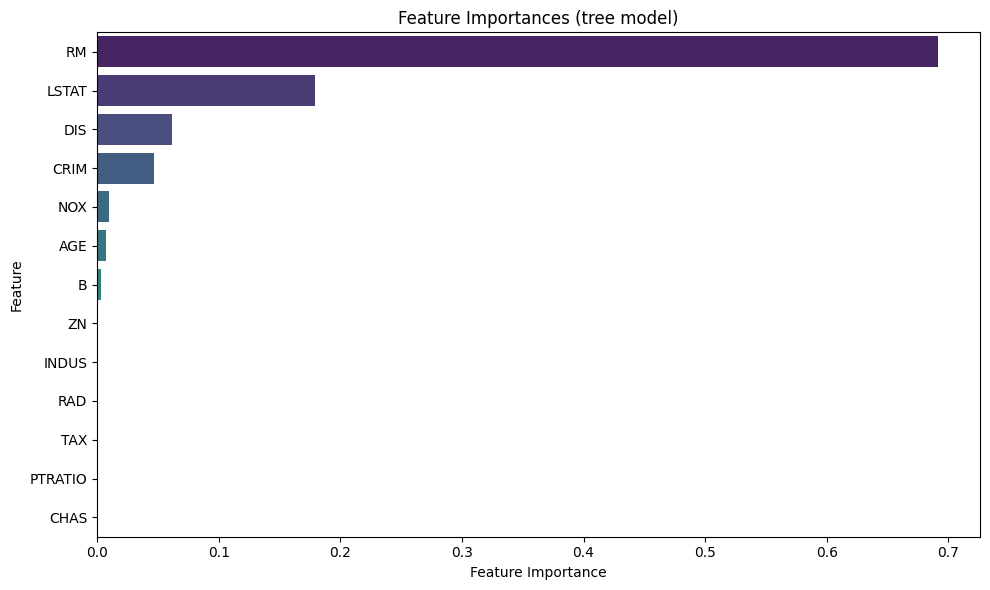

,Feature,Importance
4,RM,0.691419
11,LSTAT,0.179053
6,DIS,0.061831
0,CRIM,0.047045
3,NOX,0.009592
5,AGE,0.007713
10,B,0.003347
1,ZN,0.000000
2,INDUS,0.000000
7,RAD,0.000000


In [500]:
plot_feature_importance(decision_tree, feature_names)

Что интересно, после стандартизации результаты модели такие же, как и важность признаков, так как деревьям важен не масштаб, а отношения значений (больше/меньше), которые неизменны после стандартизации

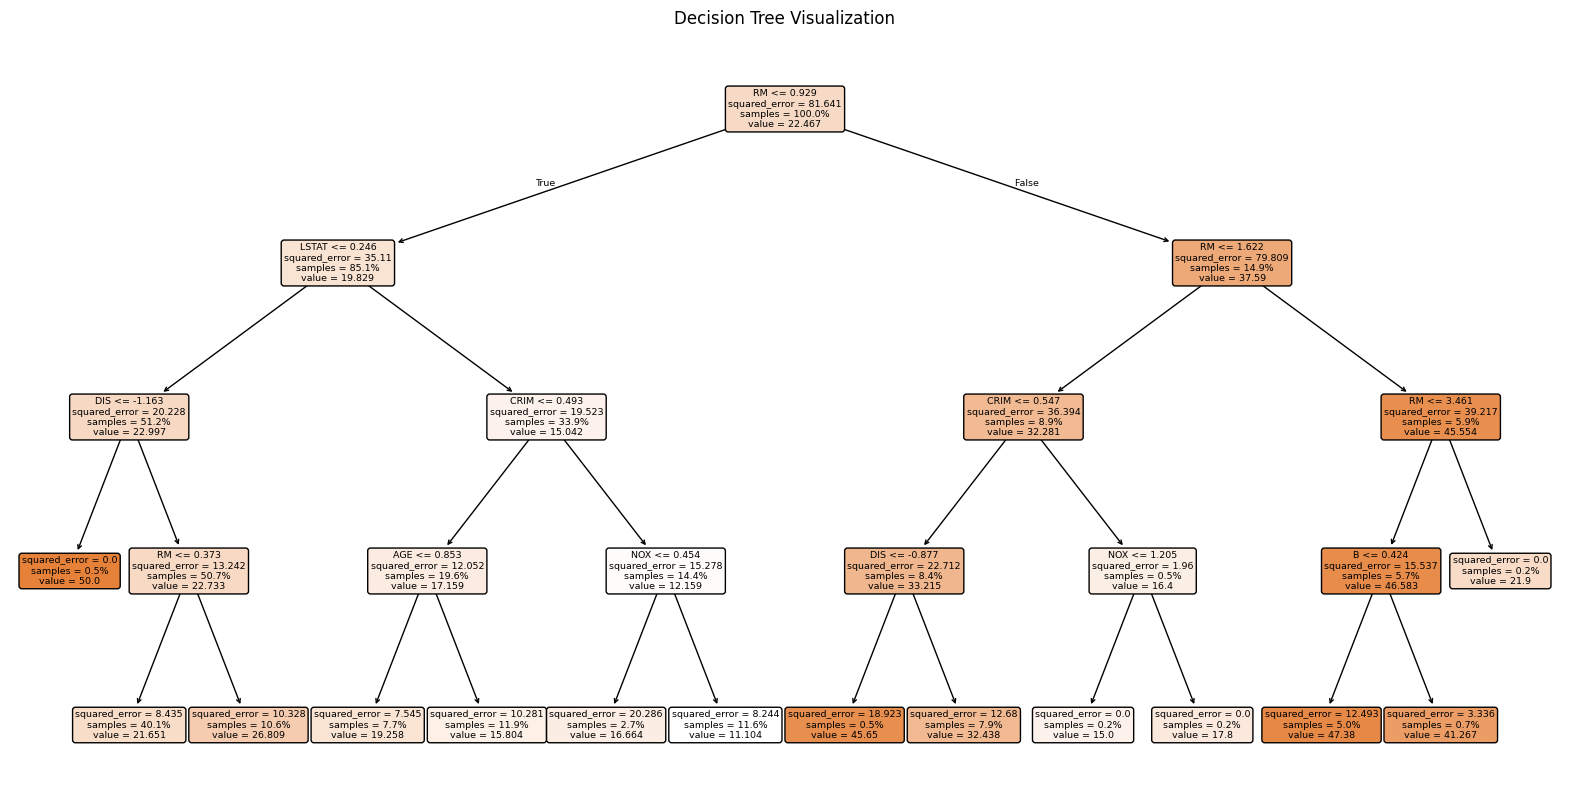

In [501]:
visualize_decision_tree(decision_tree, feature_names)

6.4 СЛУЧАЙНЫЙ ЛЕС

In [544]:
random_forest = RandomForestRegressor(random_state = SEED, n_jobs = -1)
random_forest.fit(X_processed_train, y_train)
y_pred = random_forest.predict(X_processed_test)
random_forest_metrics = evaluate_regression(y_test, y_pred, model_name = 'RandomForestRegressor')



              RANDOMFORESTREGRESSOR EVALUATION              

MAIN METRICS:
Metric  Value
   MAE 2.0152
   MSE 8.1372
   R^2 0.9147
 RMSLE 0.1446



/Users/user/ml_регрессия_Богдан/plot.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


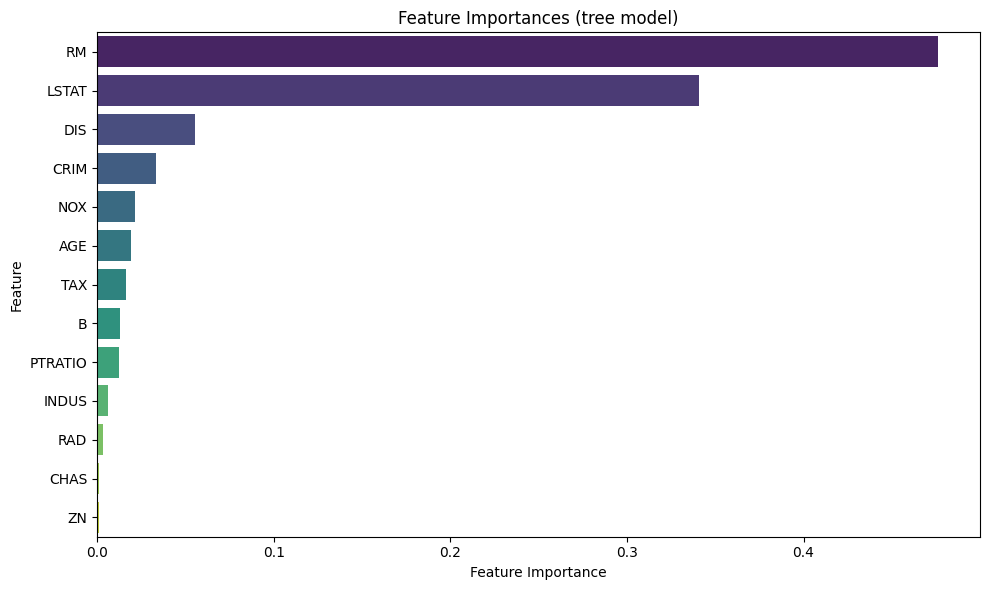

,Feature,Importance
4,RM,0.476110
11,LSTAT,0.340859
6,DIS,0.055256
0,CRIM,0.033258
3,NOX,0.021250
5,AGE,0.019490
8,TAX,0.016249
10,B,0.013064
9,PTRATIO,0.012717
2,INDUS,0.006221


In [503]:
plot_feature_importance(random_forest, feature_names)

Как видим, после AGE все поменялось и в случайном лесу даже менее информативные ранее признаки стали информативными, а все метрики улучшились в сравнении с одним деревом.

6.5 Градиентный бустинг

In [540]:
xgb = XGBRegressor(random_state = SEED)
xgb.fit(X_processed_train, y_train)
y_pred = xgb.predict(X_processed_test)
xgb_metrics = evaluate_regression(y_test, y_pred, model_name = 'RandomForestRegressor')



              RANDOMFORESTREGRESSOR EVALUATION              

MAIN METRICS:
Metric   Value
   MAE  2.2471
   MSE 10.2800
   R^2  0.8922
 RMSLE  0.1358



In [541]:


# считаем ошибку (можно взять абсолютную или квадратичную)
errors = np.abs(y_pred - y_test)

# создаем DataFrame для удобства
df_errors = pd.DataFrame({
    'index': X_test.index,
    'true_value': y_test,
    'prediction': y_pred,
    'error_abs': errors,
    'error_sq': (y_pred - y_test) ** 2
})

# сортируем по ошибке, например, по абсолютной
top_errors = df_errors.sort_values(by='error_abs', ascending=False)

# выводим, например, верхние 10
a = df.loc[top_errors.index[:10]]
a['pred'] = top_errors['prediction']
a

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,pred
369,5.66998,0.0,18.10,1,0.631,6.683,96.8,1.3567,24,666.0,20.2,375.33,3.73,50.0,35.123329
407,11.95110,0.0,18.10,0,0.659,5.608,100.0,1.2852,24,666.0,20.2,332.09,12.13,27.9,37.904305
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9,20.555782
273,0.22188,20.0,6.96,1,0.464,7.691,51.8,4.3665,3,223.0,18.6,390.77,6.58,35.2,42.781204
283,0.01501,90.0,1.21,1,0.401,7.923,24.8,5.8850,1,198.0,13.6,395.52,3.16,50.0,42.891281
180,0.06588,0.0,2.46,0,0.488,7.765,83.3,2.7410,3,193.0,17.8,395.56,7.56,39.8,46.310623
380,88.97620,0.0,18.10,0,0.671,6.968,91.9,1.4165,24,666.0,20.2,396.90,17.21,10.4,16.876570
422,12.04820,0.0,18.10,0,0.614,5.648,87.6,1.9512,24,666.0,20.2,291.55,14.10,20.8,15.913128
159,1.42502,0.0,19.58,0,0.871,6.510,100.0,1.7659,5,403.0,14.7,364.31,7.39,23.3,27.921785
41,0.12744,0.0,6.91,0,0.448,6.770,2.9,5.7209,3,233.0,17.9,385.41,4.84,26.6,31.020649


In [542]:
top_errors[:10]

,index,true_value,prediction,error_abs,error_sq
369,369,50.0,35.123329,14.876671,221.315335
407,407,27.9,37.904305,10.004305,100.086109
505,505,11.9,20.555782,8.655782,74.922568
273,273,35.2,42.781204,7.581204,57.474657
283,283,50.0,42.891281,7.108719,50.533884
180,180,39.8,46.310623,6.510623,42.388214
380,380,10.4,16.876570,6.476570,41.945956
422,422,20.8,15.913128,4.886872,23.881519
159,159,23.3,27.921785,4.621785,21.360900
41,41,26.6,31.020649,4.420649,19.542137


/Users/user/ml_регрессия_Богдан/plot.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


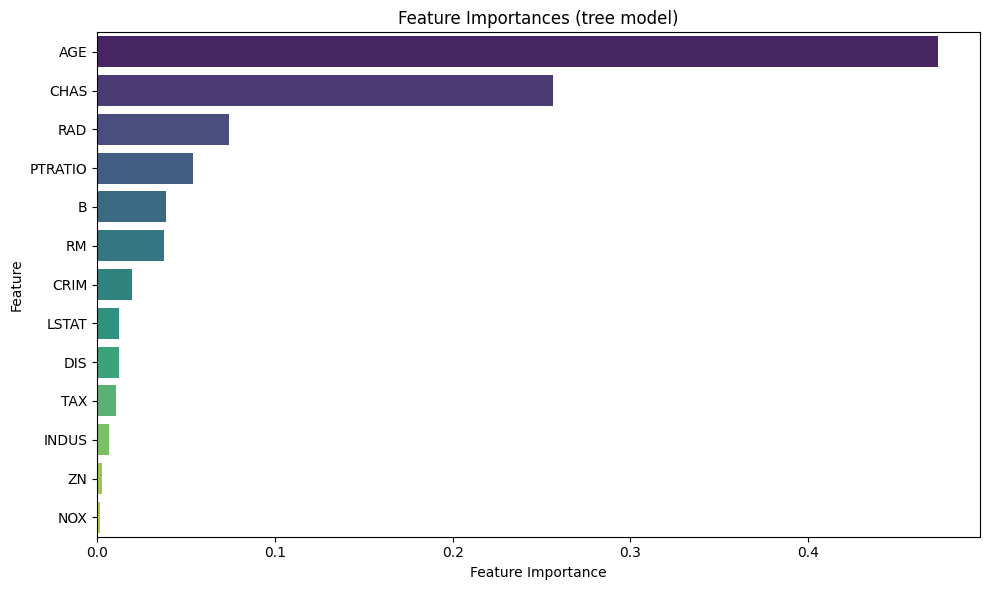

,Feature,Importance
5,AGE,0.473008
12,CHAS,0.256528
7,RAD,0.074440
9,PTRATIO,0.054080
10,B,0.038763
4,RM,0.037452
0,CRIM,0.019439
11,LSTAT,0.012413
6,DIS,0.012223
8,TAX,0.010863


In [505]:
plot_feature_importance(xgb, feature_names)

Неизменное первые три признака лидируют, как и у случайного леса и простого дерева --

кол-во комнат в жилье

доля неблагополучных

дистанция до центра города

6.6 ФИНАЛЬНОЕ СРАВНЕНИЕ МЕТРИК

In [506]:
final_metrics = {'dummy_regressor':dummy_regressor_metrics, 'lin_reg':lin_reg_metrics,
'decision_tree':decision_tree_metrics, 'random_forest':random_forest_metrics, 'xgb':xgb_metrics}
result = pd.DataFrame(final_metrics, columns = final_metrics.keys())
result

,dummy_regressor,lin_reg,decision_tree,random_forest,xgb
MAE,7.408159,3.174455,3.023906,2.015216,2.247095
MSE,95.447407,23.112380,18.715669,8.137216,10.279516
R^2,-0.001132,0.757578,0.803694,0.914650,0.892180
RMSLE,0.428526,0.210474,0.192615,0.144644,0.135829


Бэггинг и бустинг показали себя лучше всего, хотя и линейная регрессия без регуляризации смогла объяснить 76% наблюдений.